# Training and Deploying a model for Image Classification using AWS SageMaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


This notebook explores the dog dataset provided to us and utilizes the dataset to train a model, test the model and deploy it using Amazon Sagemaker and accompanied tools.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 4.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 38.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 1.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 12.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 43.7 MB/s eta 0:00:0000:0100:01


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker

import boto3
import sagemaker
import os

from sagemaker import get_execution_role
from sagemaker.tuner import CategoricalParameter, HyperparameterTuner, ContinuousParameter
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics


## Dataset
We are using the dog breed classification dataset for this notebook. The dataset contains images from 133 dog breeds divided into training, testing and validation datasets.

In [6]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data

!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
!aws s3 cp dogImages s3://aryaproject3/ --recursive

--2023-04-06 07:10:29--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.184
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  47.1MB/s    in 25s     

2023-04-06 07:11:03 (43.2 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [7]:
BUCKET = 'aryaproject3'

os.environ['SM_CHANNEL_TRAINING']=f's3://{BUCKET}/'
os.environ['SM_MODEL_DIR']=f's3://{BUCKET}/model/'
os.environ['SM_OUTPUT_DATA_DIR']=f's3://{BUCKET}/output/'

data_channels = {
    "train": "s3://{}/train/".format(BUCKET),
    "test": "s3://{}/test/".format(BUCKET),
    "valid": "s3://{}/valid/".format(BUCKET)
}

role = sagemaker.get_execution_role()

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [8]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "learning-rate": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([16, 32, 64, 128, 256, 512]),
    "early-stopping-rounds": CategoricalParameter([10, 12, 15, 17, 20])
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: (\d+\.\d+)"}]

In [9]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="HP",
    role=role,
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version="py3",
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [10]:
# TODO: Fit your HP Tuner
tuner.fit({"training": f"s3://{BUCKET}/"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.........................................................................................................................................................................................................................!


In [11]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()
print(best_estimator.hyperparameters())

hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), \
                   "learning-rate": best_estimator.hyperparameters()['learning-rate'],
                   "early-stopping-rounds": int(best_estimator.hyperparameters()['early-stopping-rounds'].replace('"', ''))
                  }
hyperparameters


2023-04-06 08:00:11 Starting - Found matching resource for reuse
2023-04-06 08:00:11 Downloading - Downloading input data
2023-04-06 08:00:11 Training - Training image download completed. Training in progress.
2023-04-06 08:00:11 Uploading - Uploading generated training model
2023-04-06 08:00:11 Completed - Resource reused by training job: pytorch-training-230406-0747-008-145f3e17
{'_tuning_objective_metric': '"Test Loss"', 'batch-size': '"16"', 'early-stopping-rounds': '"17"', 'learning-rate': '0.0019871351219908732', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"HP-2023-04-06-07-47-21-410"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-432255178055/HP-2023-04-06-07-47-21-410/source/sourcedir.tar.gz"'}


{'batch-size': 16,
 'learning-rate': '0.0019871351219908732',
 'early-stopping-rounds': 17}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [12]:
# TODO: Set up debugging and profiling rules and hooks

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "100",
        "eval.save_interval": "10"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [14]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="MAIN",
    role=role,
    instance_count=2,
    instance_type="ml.g4dn.xlarge",
    framework_version="1.8.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)
estimator.fit({"training": f"s3://{BUCKET}/"})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: MAIN-2023-04-06-08-31-59-815


2023-04-06 08:32:00 Starting - Starting the training job...
2023-04-06 08:32:38 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-04-06 08:33:26 Downloading - Downloading input data......
2023-04-06 08:34:35 Training - Downloading the training image..................
2023-04-06 08:37:37 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-06 08:37:24,539 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-06 08:37:24,568 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-06 08:37:24,571 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-06 08:37:24,845 sagemaker-training-toolkit INFO 

In [16]:
# TODO: Plot a debugging output.

job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
description

{'TrainingJobName': 'MAIN-2023-04-06-08-31-59-815',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:432255178055:training-job/MAIN-2023-04-06-08-31-59-815',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-432255178055/MAIN-2023-04-06-08-31-59-815/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch-size': '16',
  'early-stopping-rounds': '17',
  'learning-rate': '"0.0019871351219908732"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"MAIN-2023-04-06-08-31-59-815"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-432255178055/MAIN-2023-04-06-08-31-59-815/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.8.0-gpu-py3',
  'TrainingInputMode': 'File',
  'EnableSageMakerMetricsTimeSeries': True},
 'RoleArn': 'arn

In [17]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-04-06 10:33:54.335 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-04-06 10:33:54.346 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-432255178055/MAIN-2023-04-06-08-31-59-815/debug-output


In [18]:
trial.tensor_names()

[2023-04-06 10:33:58.980 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-04-06 10:34:00.001 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [19]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

95

In [20]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

6

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

INFO:matplotlib.font_manager:generated new fontManager


In [22]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    print(f"[INFO] Getting data in {len(steps)} steps")
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
        print(".", end="")
    return steps, vals

In [23]:
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(20, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

[INFO] Getting data in 95 steps
...............................................................................................loaded TRAIN data
[INFO] Getting data in 6 steps
......loaded EVAL data
completed TRAIN plot
completed EVAL plot


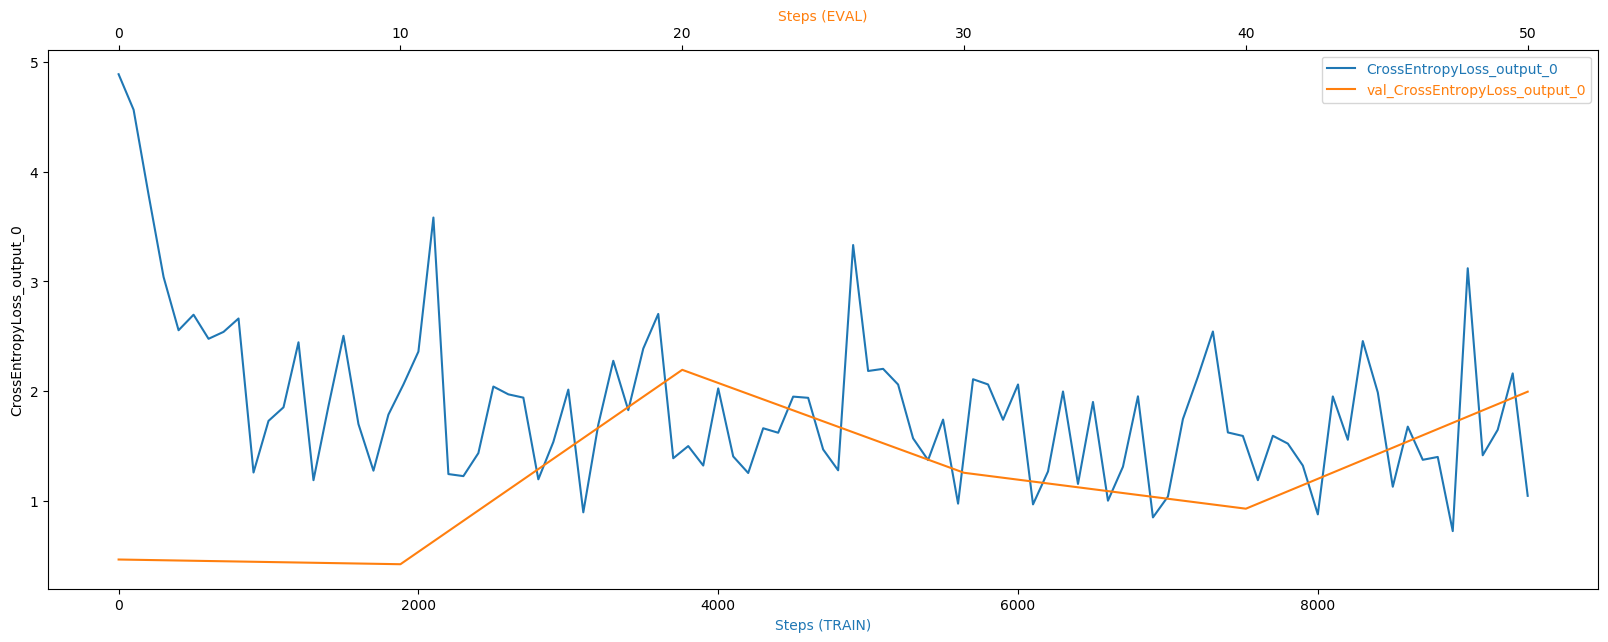

In [24]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [25]:
import os
import IPython

In [26]:
# TODO: Display the profiler output

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
! aws s3 ls {rule_output_path} --recursive

2023-04-06 09:10:39     490585 MAIN-2023-04-06-08-31-59-815/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-04-06 09:10:39     358380 MAIN-2023-04-06-08-31-59-815/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-04-06 09:10:33        942 MAIN-2023-04-06-08-31-59-815/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-04-06 09:10:33      21351 MAIN-2023-04-06-08-31-59-815/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-04-06 09:10:33       1940 MAIN-2023-04-06-08-31-59-815/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-04-06 09:10:33        326 MAIN-2023-04-06-08-31-59-815/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-04-06 09:10:33       2133 MAIN-2023-04-06-08-31-59-815/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
2023-04-06 09:10:33        546 MAIN-2023-04-06-08-31-59-815/

In [27]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-432255178055/MAIN-2023-04-06-08-31-59-815/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-432255178055/MAIN-2023-04-06-08-31-59-815/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-432255178055/MAIN-2023-04-06-08-31-59-815/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-432255178055/MAIN-2023-04-06-08-31-59-815/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-432255178055/MAIN-2023-04-06-08-31-59-815/rule-output/ProfilerReport/profil

In [28]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [29]:
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [31]:
# TODO: Deploy your model to an endpoint

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )
        
pytorch_model = PyTorchModel(model_data=estimator.model_data, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')# TODO: Add your deployment configuration like instance type and number of instances

INFO:sagemaker:Creating model with name: pytorch-inference-2023-04-06-10-38-04-826
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-04-06-10-38-05-652
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-04-06-10-38-05-652


-----!

In [32]:
import requests
from PIL import Image
import io

In [43]:
# TODO: Run an prediction on the endpoint

request_dict={ "url": "http://vision.stanford.edu/aditya86/ImageNetDogs/images/n02096294-Australian_terrier/n02096294_1400.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)


bytes

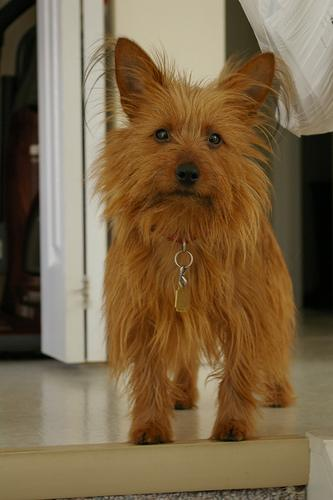

In [44]:
Image.open(io.BytesIO(img_bytes))

In [45]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [46]:
import numpy as np
np.argmax(response)

12

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()